In [1]:
import torch
import os
import tqdm
import Model
import Utils
import Loss
import Deeplearning
import torch.nn             as nn
import matplotlib.pyplot    as plt
import numpy                as np
import torch.optim          as optim

Utils.set_seed(42)
device = 'cuda'

In [2]:
prediction_horizon      = Utils.prediction_horizon
prediction_input_size   = Utils.prediction_input_size
epochs                  = Utils.num_epochs
_divition_factr         = Utils.Noise_division_factor

model     = Model.Encoder_Decoder(prediction_input_size).to(device)
criterion = Loss.custum_loss(alpha=Utils.alpha)#torch.nn.MSELoss()
optimizer = optim.SGD(
                        model.parameters(),
                        lr=5e-2,
                        momentum=0.9,
                        weight_decay=1e-4
                        )

In [3]:
npz_file_path = "Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[1.5, -1.5].npy"
loaded_data = Utils.read_npz_file(npz_file_path)
data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)

_Model_name = f"Gamma ={npz_file_path.split(' ')[0].split('=')[-1]} {prediction_input_size=} cu_loss={Utils.Eigen} init=({npz_file_path.split('[')[-1].split(']')[0]}) noise_factor={_divition_factr} gammas=0.37-0.29"

model, optimizer, report = Deeplearning.train(
                                                data_tensor                 = data_tensor[:250_000],
                                                prediction_input_size       = prediction_input_size,
                                                prediction_horizon          = Utils.prediction_horizon,
                                                _divition_factr             = _divition_factr,
                                                
                                                model                       = model,
                                                model_name                  = _Model_name ,
                                                epochs                      = 1,#epochs,
                                                load_saved_model            = False,
                                                ckpt_save_freq              = 1 ,
                                                ckpt_save_path              = os.path.join("Saved" ,".Checkpoints"),
                                                ckpt_path                   = os.path.join("Saved" ,".Checkpoints","ckpt_cu_loss=False init=(1.5, 1.5) noise_factor=7 _epoch1.ckpt") ,
                                                report_path                 = "Saved" ,
                                                
                                                criterion                   = criterion,
                                                optimizer                   = optimizer,
                                                lr_scheduler                = None,
                                                sleep_time                  = None,
                                                Validation_save_threshold   = None,
                                                device                      = 'cuda'    ,
                                                )

train:   0%|          | 0/1249 [00:00<?, ?it/s]

100%|██████████| 1/1 [08:29<00:00, 509.36s/it]


# ChangeLog

1.  waiting to solution settle
2.  using only th acceleration data instead of the v and x
3.  

# Note
1.  try to remove the drop out in LSTM

2.  BE SURE data for chaotic case in Clean. (Training)
3.  Be sure for integration data is noise free.(Integrating)

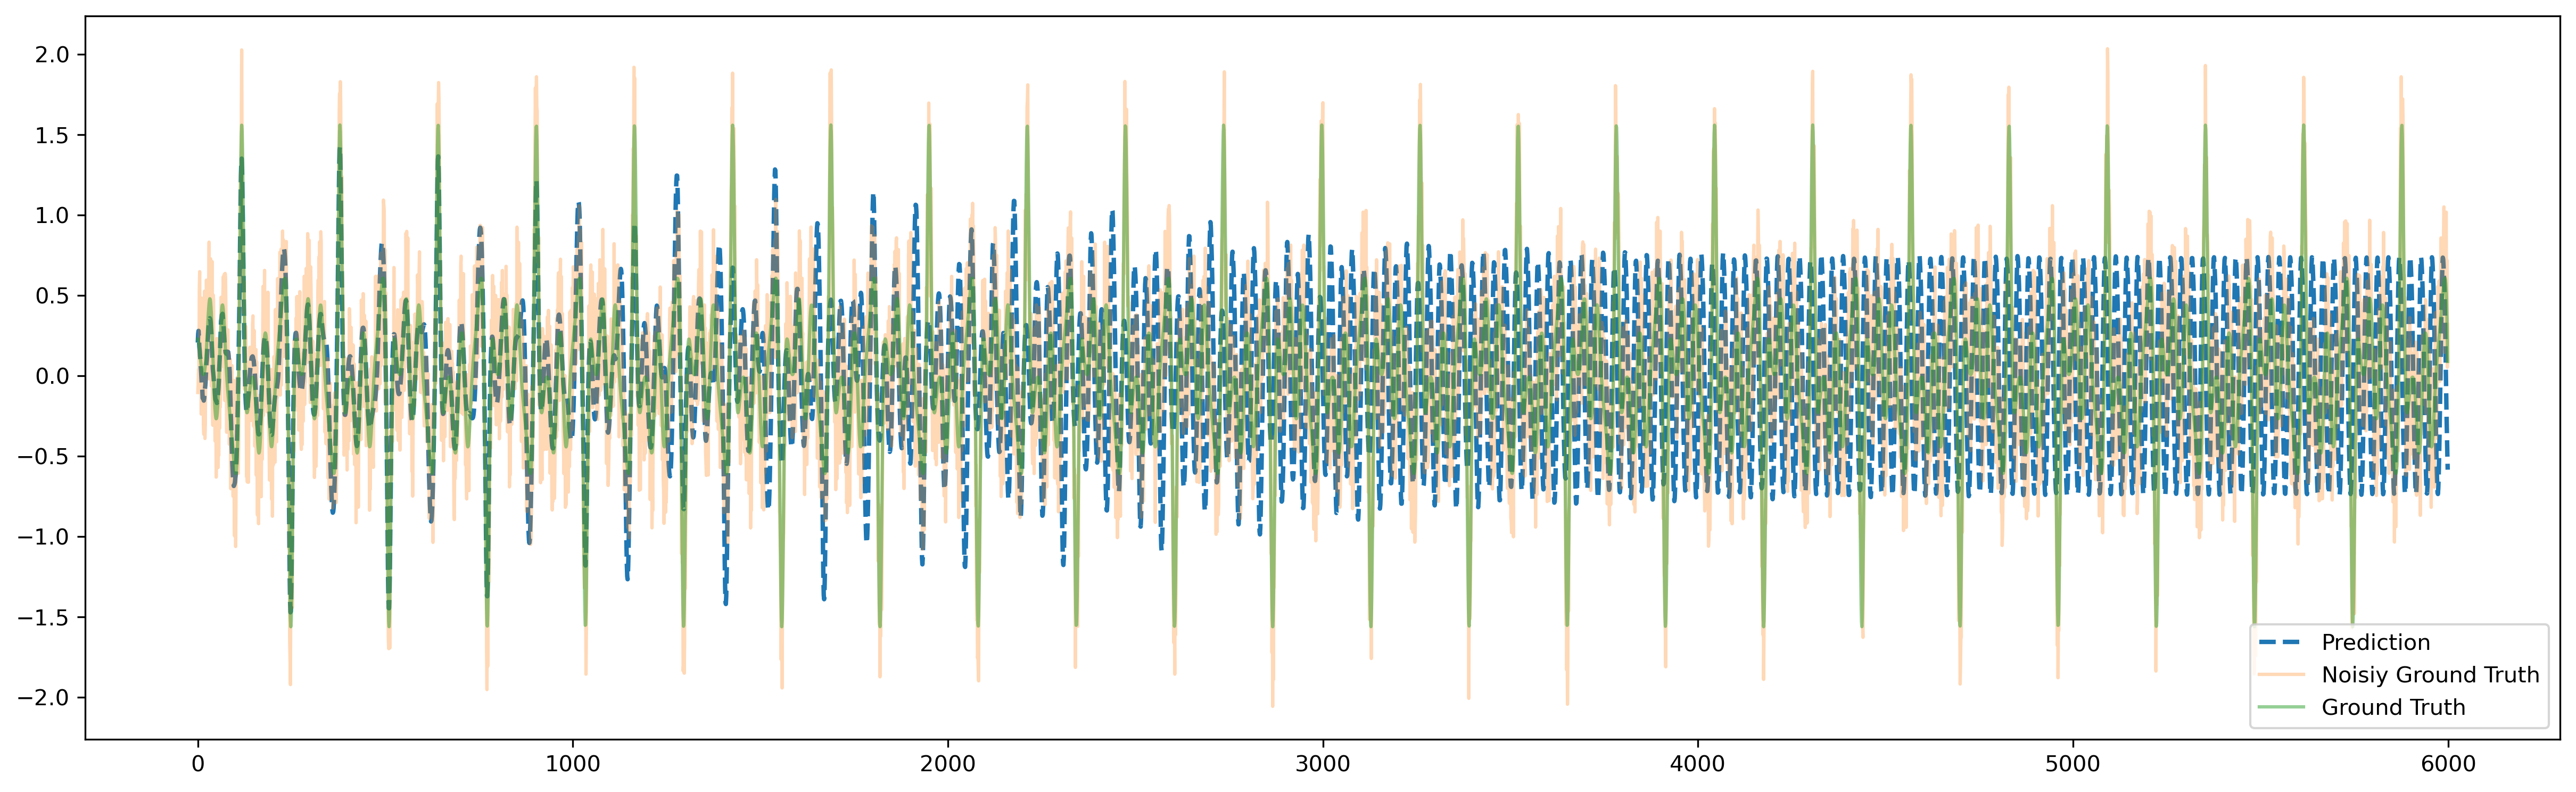

In [20]:
npz_file_path = "Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[0, 0.5].npy"
loaded_data = Utils.read_npz_file(npz_file_path)
data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)

# model.load_state_dict(torch.load(os.path.join(directory_path)))
# model.eval()


_divition_factr = 1

with torch.inference_mode():
    Batch = 10
    pred_hor = 6000
    x = data_tensor[Batch*prediction_input_size:(Batch+1)*prediction_input_size]+((2*torch.rand(size=[prediction_input_size],device=device)-1)/(2*_divition_factr))
    y = data_tensor[(Batch+1)*prediction_input_size:(Batch+1)*prediction_input_size+pred_hor]

    prediction_list = torch.zeros(size=[pred_hor]).to(device)

    decoder_hidden, decoder_cell = torch.zeros(size=[2,prediction_input_size],device=device), torch.zeros(size=[2,prediction_input_size],device=device)
    for i in range(pred_hor):
        # prediction = inception.forward(x)
        prediction,(decoder_hidden, decoder_cell) = model.forward(x.unsqueeze(0),decoder_hidden, decoder_cell)
        x =  torch.cat([x[1:],prediction],dim=0)
        prediction_list[i] = prediction


plt.figure(figsize=(20, 6),dpi=300)
plt.plot((prediction_list[:]                                             ).detach().cpu().numpy() , linewidth=2,linestyle='dashed', label="Prediction")
plt.plot((y[:]+(2*torch.rand(size=[pred_hor],device=device)-1)/(2*_divition_factr) ).detach().cpu().numpy() , alpha=0.3, label="Noisiy Ground Truth")
plt.plot((y[:]                                                           ).detach().cpu().numpy() , alpha=0.5, label="Ground Truth")
plt.legend()